# EE4375: Second Lab Session: Finite Difference Method for the Poisson Equation on the Unit Interval

The **goals** of this second lab session of the [EE4375 Course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) are three-fold. 

The **first goal** is to implement a second order finite difference method to solve the one-dimensional Poisson equation supplied with Dirichlet and Neumann boundary conditions on a spatially uniform mesh. The interval extending from $x=0$ to $x=1$ is used as computational domain. This domain is denoted by $\Omega$. The boundary value problem that we wish solve can thus be stated as: given the source term $f(x)$ and the boundary flux $\alpha$, find the function $u(x)$ that satisfied the following three conditions: 
1. on the interior of the domain of computation $0 < x < 1$ holds the differential equation stating that $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ (observe the sign in front of the double derivative of $u(x)$ in the differential equation); 
2. on the left-most boundary $x=0$ holds the homogeneous Dirichlet boundary conditions stating that $u(0) = 0$ (the extension to non-homogeneous Dirichlet is left as an exercise);  
3. on the right-most boundary $x=1$ holds the non-homogeneous Neumann boundary condition stating that $u'(1) = \alpha$; 

Both the assembly and the solve of the linear system will be explored. In the assembly process, the stencil representation of the linear system and a loop over nodes in the mesh will be employed. In the solve process, a sparse direct linear solver will be employed. This solver is based on the LU factorization of the coefficient matrix. Having computed the numerical solution, we also plot the first and second derivative of the computed solution. 

**Convention** employed in the code are as follows: 
1. the mesh is assumed to have $N$ elements (intervals or sections). The mesh thus has $N+1$ nodes (or points). These $N+1$ can be grouped into $N-1$ internal nodes (not lying on the boundary) and $2$ boundary nodes (and left and right boundary node); 
2. the boundary conditions are explicitly accounted in both the matrix $A$ and the right-hand side vector $f$. The matrix $A$ and the right-hand side vector $f$ thus have size $N+1$-by-$N+1$ and $N+1$-by-$1$, respectively; 

The **second goal** is to compare the numerical solution obtained with an one-dimensional analytical reference solution. An example is provided in the 2-lab-

The **third goal** is apply the one-dimensional finite difference method to a coil-core-air configuration and to explore the spatial distribution of the potential, the perpendicular magnetic flux component and the perpendicular magnetic field component. 

**Reference solutions** for the assignents in this notebook can be generated either symbolically or numerically:
1. symbolic reference solutions can be generated using the function [dsolve](https://docs.sympy.org/latest/modules/solvers/ode.html#sympy.solvers.ode.dsolve) of the sympy package. This function can be used with the option <i>bcs</i> to specify the boundary conditions; 
2. numerical reference solutions can be generated using e.g. the function [BVProblem](https://docs.sciml.ai/DiffEqDocs/stable/tutorials/bvp_example/) of the DifferentialEquations.jl package, the [ApproxFun.jl](https://juliaapproximation.github.io/ApproxFun.jl/latest/generated/ODE/) package or the [BSplineKit.jl](https://jipolanco.github.io/BSplineKit.jl/dev/generated/heat/) package. 

This lab session complements the lecture slides [block1-finite-difference-method.pdf](https://github.com/ziolai/finite_element_electrical_engineering/blob/main/slides/block1-finite-difference-method.pdf) available at [EE4375 GitHub Directory](https://github.com/ziolai/finite_element_electrical_engineering/tree/main/slides).

## Import Packages

In [2]:
using LinearAlgebra
using SparseArrays

using BenchmarkTools 

using Plots

## Section 1: Script Version
The script version allows for easy experimentation.

### Section 1.1: First Example: Analytically Specified Source Function $f(x)$

This first example uses the homogeneous Dirichlet boundary condition $u(x=0) = 0$ in the left end-point and the non-homogeneous Neumann boundary condition $\frac{d\,u}{dx}(x=1) = \alpha$ in the right end-point. The source function $f(x)$ is chosen as $f(x) = 1$ to mimmic the example in the slides. 

Exercises:
1. study the code below; 
2. run the code below for various values (positive, negative and zero) for $\alpha$. Compare the solutions obtained with the solutions given in the slides. Give an interpretation to solutions with positive and negative values of $\alpha$ with the same absolute value; 
3. change the expression $f(x)$. Obtain and plot the analytical solution. Compare with analytical solution.
4. explore how the error in the numerically computed solution changes as the mesh width $h$ is reduced. The error is defined as the difference between the analytically and numerical solution. Compute the numerical solution of a sequence of finer meshes. Refine the mesh by a factor of two at each step. Use for instance $h = 1/4$, $h=1/8$, $h=1/16$ and so on. For each mesh, compute the error in the numerical solution as the difference between numerical approximation and analytical solution. Plot the absolute values of this error vs. the spatial coordinate $x$ using a semilogy-axis for various values of $h$. Tabulate the norm (sum of square errors) of the error for various values of $h$. To explore the rate at which the error norm is reduced, plot the error norm vs. the mesh width on a semilogy-scale. Compute the slope of the line shown in the graph. Relate the value of the slope to the order of the numerical scheme used.   

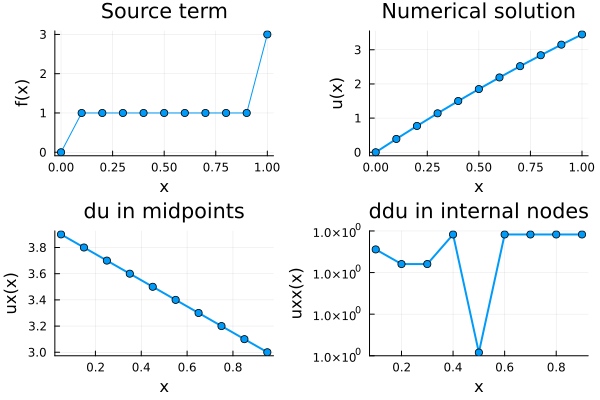

GKS: Possible loss of precision in routine SET_WINDOW


In [3]:
#..construct the 1D mesh
nelements = 10; nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2;

#..construct the source function 
f = ones(size(x)); 
alpha = 3;

#..construct the coefficient matrix with our the boundary conditions 
e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=-1/h;   A[end,end] = 1/h;    f[end] = alpha;  
    
#..solve the linear system
u = A \ f; 

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = [i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:nelements, j=1:nnodes]
BT = Transpose(B)

#..compute ux and uxx in the post-processing stage 
ux = B*u; 
uxx = BT*ux; 

#..plot the source term and computed solution  
p1=plot(x,f,shape=:circle,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Source term")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerical solution")

p3=plot(xmid,ux,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("ux(x)")
title!("du in midpoints")

p4=plot(x[2:end-1],uxx[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("uxx(x)")
title!("ddu in internal nodes")

plot(p1,p2,p3,p4,layout=(2,2))

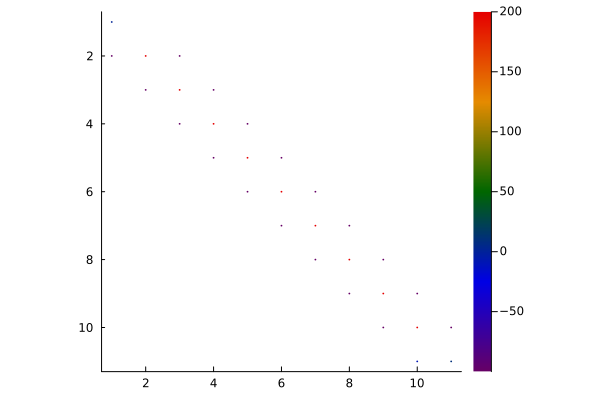

In [4]:
spy(A, markercolor = :darkrainbow)

### Section 2.1: Second Example: Analytically Specified Source f(x) Modeling a Pulse, Point Charge or a Single Wire 
This second example uses the homogeneous Dirichlet boundary condition in both the left end-point and the right end-point. The source function $f(x)$ is specified as a Gaussian pulse.

Exercises: 
1. study and run the code below; 
2. change location and width of the pulse, rerun the code and give an interpretation to the solution obtained; 
3. extend to more pulses with various, possibly negative, amplitudes, rerun the code and give an interpretation to the solution obtained;
4. verify that the coefficient matrix is stored as a sparse matrix. Use to this end the Julia function sparse() and the function typeof().  

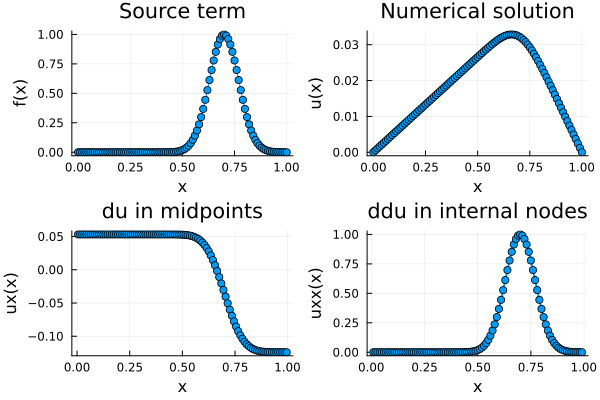

In [5]:
#..construct the 1D mesh
nelements = 100; nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2;

#..construct the source function 
#..x0 is scalar. Observe the use of pointwise operations (broadcast in Julia)
x0 = .7; f = exp.( - (x.-x0).^2 ./0.01 ); 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  
    
#..solve the linear system
u = A \ f; 

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = [i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:nelements, j=1:nnodes]
BT = Transpose(B)

#..compute ux and uxx in the post-processing stage 
ux = B*u; 
uxx = BT*ux; 

#..plot the source term and computed solution  
p1=plot(x,f,shape=:circle,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Source term")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerical solution")

p3=plot(xmid,ux,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("ux(x)")
title!("du in midpoints")

p4=plot(x[2:end-1],uxx[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("uxx(x)")
title!("ddu in internal nodes")

plot(p1,p2,p3,p4,layout=(2,2))

## Section 3: One-Dimensional Mesh Generation

In [7]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  Nodes::Vector{Float64}
end 

In [8]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    Nodes = Vector{Float64}(0:h:1)    
    mesh = Mesh(nnodes,nelements,Nodes)     
    return mesh;
end 

genMesh (generic function with 1 method)

In [9]:
# test function for type stability 
@code_warntype genMesh(4);

MethodInstance for genMesh(::Int64)
  from genMesh(nelements::Int64) in Main at In[8]:3
Arguments
  #self#::Core.Const(genMesh)
  nelements::Int64
Locals
  mesh::Mesh
  Nodes::Vector{Float64}
  nnodes::Int64
  h::Float64
Body::Mesh
1 ─ %1 = Main.Mesh::Core.Const(Mesh)
│        (h = 1 / nelements)
│        (nnodes = nelements + 1)
│   %4 = Core.apply_type(Main.Vector, Main.Float64)::Core.Const(Vector{Float64})
│   %5 = (0:h:1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│        (Nodes = (%4)(%5))
│        (mesh = Main.Mesh(nnodes, nelements, Nodes))
│   %8 = Base.convert(%1, mesh)::Mesh
│   %9 = Core.typeassert(%8, %1)::Mesh
└──      return %9



In [10]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time genMesh(10);
@time genMesh(100);
@time genMesh(1000);
@time genMesh(10000);

  0.000004 seconds (1 allocation: 144 bytes)
  0.000004 seconds (1 allocation: 896 bytes)
  0.000005 seconds (1 allocation: 8.000 KiB)
  0.000016 seconds (2 allocations: 78.234 KiB)


## Section 4: Linear System Assembly

### Section 1.4: Assemble Stiffness Matrix

In [11]:
# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
    A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
    A = (1/h2)*A;     
   
    return A; 
    
end

genStiffMat (generic function with 1 method)

In [12]:
mesh = genMesh(10);
@code_warntype genStiffMat(mesh)

MethodInstance for genStiffMat(::Mesh)
  from genStiffMat(mesh::Mesh) in Main at In[11]:2
Arguments
  #self#::Core.Const(genStiffMat)
  mesh::Mesh
Locals
  A::Tridiagonal{Float64, Vector{Float64}}
  e::Vector{Float64}
  h2::Float64
  h::Float64
  nnodes::Int64
  nelements::Int64
Body::Tridiagonal{Float64, Vector{Float64}}
1 ─       (nelements = Base.getproperty(mesh, :nelements))
│         (nnodes = nelements + 1)
│         (h = 1 / nelements)
│         (h2 = h * h)
│         (e = Main.ones(nnodes))
│   %6  = e::Vector{Float64}
│   %7  = Base.lastindex(e)::Int64
│   %8  = (2:%7)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(2), Int64])
│   %9  = Base.getindex(%6, %8)::Vector{Float64}
│   %10 = -%9::Vector{Float64}
│   %11 = (2 * e)::Vector{Float64}
│   %12 = e::Vector{Float64}
│   %13 = Base.lastindex(e)::Int64
│   %14 = (2:%13)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(2), Int64])
│   %15 = Base.getindex(%12, %14)::Vector{Float64}
│   %16 = -%15::Vector{Float64}
│   

In [13]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(10);    @time genStiffMat(mesh); 
mesh = genMesh(100);   @time genStiffMat(mesh);
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh);

  0.000006 seconds (11 allocations: 1.359 KiB)
  0.000005 seconds (11 allocations: 1.359 KiB)
  0.000006 seconds (11 allocations: 7.969 KiB)
  0.000008 seconds (11 allocations: 71.719 KiB)
  0.000033 seconds (20 allocations: 703.828 KiB)


### Section 2.4: Assemble Right-Hand Side Vector

In [14]:
fsource(x) = x*(x-1)
fsource(x) = sin(π*x)

function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes)
   
    return f; 
end

genVector (generic function with 1 method)

In [15]:
@code_warntype genVector(mesh, fsource)

MethodInstance for genVector(::Mesh, ::typeof(fsource))
  from genVector(mesh, sourceFct::F) where F in Main at In[14]:4
Static Parameters
  F = typeof(fsource)
Arguments
  #self#::Core.Const(genVector)
  mesh::Mesh
  sourceFct::Core.Const(fsource)
Locals
  f::Vector{Float64}
  nodes::Vector{Float64}
Body::Vector{Float64}
1 ─      (nodes = Base.getproperty(mesh, :Nodes))
│   %2 = Base.broadcasted(sourceFct, nodes)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(fsource), Tuple{Vector{Float64}}}
│        (f = Base.materialize(%2))
└──      return f



In [16]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time f = genVector(mesh,fsource); # force function compilation
mesh = genMesh(10);    @time f = genVector(mesh,fsource);
mesh = genMesh(100);   @time f = genVector(mesh,fsource);
mesh = genMesh(1000);  @time f = genVector(mesh,fsource);
mesh = genMesh(10000); @time f = genVector(mesh,fsource);

  0.036941 seconds (11.36 k allocations: 549.302 KiB, 99.95% compilation time)
  0.000004 seconds (1 allocation: 144 bytes)
  0.000004 seconds (1 allocation: 896 bytes)
  0.000008 seconds (1 allocation: 8.000 KiB)
  0.000048 seconds (2 allocations: 78.234 KiB)


## Section 5: Solve Process 

In [17]:
#..set exact solution with homogeneous Dirichlet boundary conditions on both sides.. 
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct1(x) = x*(x-1)
uexactFct2(x) = sin(π*x)

#..set exact solution with homogeneous Dirichlet left and homogeneous Neumann on the right..  
#..fourth derivative is zero - three point difference scheme is exact 
uexactFct3(x) = -0.5*x*x + x 
uexactFct4(x) = sin(π/2*x)

#..set exact solution with periodic boundary conditions: equal values and equal normal derivatives..    
uexactFct5(x) = sin(2*π*x) 

#..set source function: observe the minus sign: f(x) = - u''(x).. 
#..(we would like to set f(x) automatically given u(x))..  
fsourceFct1(x) = -2
fsourceFct2(x) = π*π*sin(π*x)

fsourceFct3(x) = 1. 
fsourceFct4(x) = π^2/4*sin(π/2*x)

fsourceFct5(x) = (4*π*π+1)*sin(2*π*x)

fsourceFct5 (generic function with 1 method)

" Setting periodic boundary conditions "

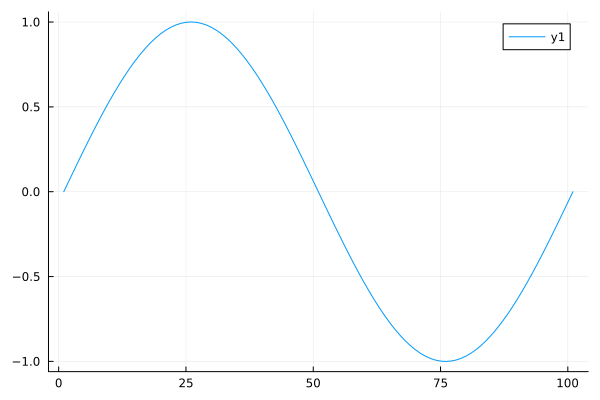

In [18]:
function genSolution(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 
    
    #..set homogeneous Dirichlet boundary conditions at both end points  
    if (false)
        A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
        A[end,end] = 1.; A[end,end-1] = 0.; f[end] = 0.;
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-1")
        A[1,1] = 1.;        A[1,2] = 0.;         f[1] = 0.;
        A[end,end] = 1/h ;  A[end,end-1] = -1/h; f[end] = 0;        
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-2")
        A[1,1] = 1.;        A[1,2] = 0.;         f[1] = 0.;
        A[end,end] = 1/h ;  A[end,end-1] = -1/h; f[end] = h/2*f[end];        
    elseif (true)
        display(" Setting periodic boundary conditions ")
        A = sparse(A)
        A[1,end-1] = -1/h2; 
        A[end,2]   = -1/h2;
    else 
        error(" genSolution::Error::Boundary conditions not set")
    end 
    u = (A+UniformScaling(1.))\f 
    return u,A,f  
end

N = 100
#N = 4 
mesh = genMesh(N)
A = genStiffMat(mesh) # force compilation 
f = genVector(mesh,fsourceFct5) # force compilation
u, A, f = genSolution(mesh,A,f) # force compilation 
# @time u = genSolution(A,f)

plot(u)

In [19]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = genMesh(10);    @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u = genSolution(mesh,A,f);
mesh = genMesh(100);   @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u = genSolution(mesh,A,f);
mesh = genMesh(1000);  @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u = genSolution(mesh,A,f);
mesh = genMesh(10000); @time A = genStiffMat(mesh); f = genVector(mesh,fsource); 
@time u = genSolution(mesh,A,f);

  0.000011 seconds (11 allocations: 1.359 KiB)


" Setting periodic boundary conditions "

  0.000533 seconds (430 allocations: 58.031 KiB)
  0.000007 seconds (11 allocations: 7.969 KiB)


" Setting periodic boundary conditions "

  0.000968 seconds (430 allocations: 186.898 KiB)
  0.000008 seconds (11 allocations: 71.719 KiB)


" Setting periodic boundary conditions "

  0.001756 seconds (434 allocations: 1.357 MiB)
  0.000062 seconds (20 allocations: 703.828 KiB)


" Setting periodic boundary conditions "

  0.005938 seconds (445 allocations: 13.038 MiB)


## Section 6: Convergence Towards the Exact Solution 

### First Study: Converge of the Numerical Solution to the Exact Solution as the Mesh Width is Decreased
Observe that: 
1. for the convergence study that follows, we will employ the exact solution. This exact solution is typically not known in pracxtical applications;  
2. the three-point central finite difference scheme employed is second order accurate (use Taylor for demonstration). This implies that each time the mesh width is reduced by a factor of two (three) the error is reduced by a factor of four (nine). The graph of the logarithm of the error norm vs. the number of elements is a line with slope two (three); 
3. the second order finite difference scheme has zero truncation error for polynomial up to degree 3 in x . These polynomials should thus be approximated exactly (i.e. the error should be zero);  

To do: 
1. implement unit test for the code; 

In [20]:
function genError(mesh, u, exactFct::F) where F 
    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    ue = exactFct.(nodes)
    
    #..compute the error
    err = ue - u  
    
    #..compute error norm 
    errnrm = norm(err,Inf)
    
    return err, errnrm; 
end

genError (generic function with 1 method)

" Setting periodic boundary conditions "

" Setting periodic boundary conditions "

" Setting periodic boundary conditions "

" Setting periodic boundary conditions "

" Setting periodic boundary conditions "

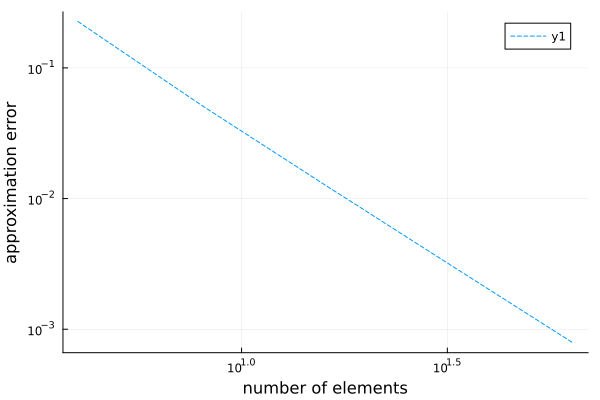

In [21]:
elementNumbers = [2^p for p in 2:6]
errnrm = zeros(length(elementNumbers)) 
err = Vector{Vector{Float64}}(undef,length(elementNumbers))

for (i,N) in enumerate(elementNumbers)
    mesh = genMesh(N);
    A = genStiffMat(mesh); 
    f = genVector(mesh,fsourceFct5); 
    u,_ = genSolution(mesh,A,f);
    err[i], errnrm[i] = genError(mesh, u, uexactFct5)
end 

plot(elementNumbers, errnrm, ls=:dash, xaxis=:log, yaxis=:log)
xlabel!("number of elements")
ylabel!("approximation error")

In [22]:
errnrm

5-element Vector{Float64}:
 0.22661871528356015
 0.05165155748243655
 0.012626764868542306
 0.003139191821050602
 0.0007837101179011263

### Second Study: Converge of the Numerical Solution to the Exact Solution as the Polynomial Degree of the Appproximation is Increased 

Assume as before the analytical (exact) solution to be known. Replace code as above by code that employs [MethodofLines](https://docs.sciml.ai/MethodOfLines/stable/). Study how the numerical error decreases as the polynomial degree of the approximation is increased keeping the mesh fixed.   

## Section 7: A Closer Look into the Linear Algebra  

### First Study: backslash vs. explicit inverse

Compare solving the linear system for u using u = A \ f with using the explicit inverse of A. The latter can be implemented in two first. First compute the explicit inverse of A using B = inv(A) (see small example below). Next compute u by u = B  * f. Use the @btime macro to compare the two alternatives on a sequence of problems of increasing size. 

In [23]:
#?inv

In [24]:
A = [1 2; 3 4]
print(A)
B = inv(A)
print(B)
C = A * B 
print(C)

[1 2; 3 4][-1.9999999999999996 0.9999999999999998; 1.4999999999999998 -0.4999999999999999][1.0 0.0; 8.881784197001252e-16 0.9999999999999996]

### Second Study: dense vs. sparse 

Compare runtimne of solver with A dense and A sparse. The sparse command allow to convert from dense to sparse. Use the @btinme macro to compare both variants. 

### Third Study: direct vs. iterative 

Compare runtime of solver using direct and iterative (CG preconditioned by for instance algebraic multigrid) for various problem sizes.

### Fourth Study: spectral analysis of the coefficient matrix 

## Section 8: An Application of a Coil and Yoke Configuration 

### First Study: Magnetic Field Induced by Winding (multi-turn coil) in Air 

<b> Problem Description:</b> Here we consider the computation of the magnetic flux (or B-field) and the magnetic field (or H-field) caused by the current in a winding (or multi-turn coil) surrounded by air. We consider the current through the coil (denoted by $f(x)$) to be known. We first compute the $z$-component of the magnetic vector potential (denoted by $u(x)$) by solving a differential equation supplied with boundary conditions for $u(x)$ (Can you derive this differential equation?). Next we compute the $y$-component of the magnetic flux of $B_y = \partial u / \partial x$ (as ${\mathbf B} = \nabla \times {\mathbf A}$) (Can you provide details here). We assume for simplicity that the magmetic permeability of vacuum is equal to one. This allows to say that $B_y$ and $H_y$ have the same value (in their respective physical dimensions).    

<b> Discussion of Numerical Results Obtained:</b> Values obtained for $B_y$ show that as expected the flux passing through the center of the coil is equal in value and opposite in sign than the flux passing through the exterior of the coil. The magnetic flux over the entire domain is equal to zero, i.e., $\text{flux} = \int_0^1 B_y \, dx = \int_0^1 u_x \, dx = [u]_{x=0}^{x=1} = u(x=1) - u(x=0) = 0 - 0 = 0$ due to the homogeneous boundary conditions imposed. The slope of the magnetic flux in the center is larger than in the exterior regions. 

<b> Please note that:</b>
1. the derivative $u_x$ is computed in the midpoints of the intervals of the mesh;
2. the value of the computed derivative should be disgarded in the end-nodes; 
3. the double derivative $u_{xx}$ coincides with $-f(x)$; 

<div>
<img src="figures/coil-in-air.png" width=500/>
<center> Figure-1: Coil in air configuration.  
    </center>
</div>

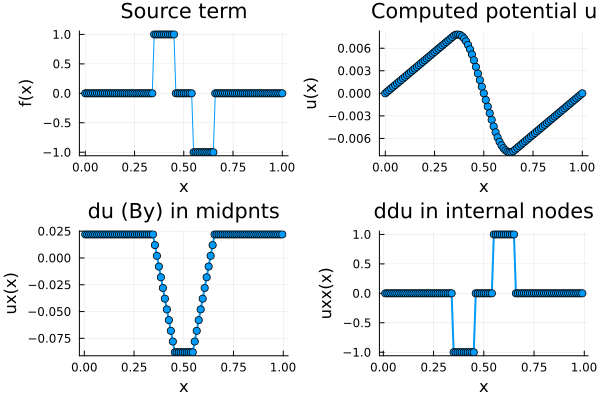

In [25]:
 #..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 

#..use superposition to compute total f 
f = fleft+fright; 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  

#..construct the matrix enabling the post-processing 
#..beware of B and BT being rectangular 
B = [i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)

#..solve the linear system
u = A \ f; 

#..compute ux and uxx 
ux = B*u; 
uxx = -BT*ux; 

#..plot the source term and computed solution  
p1=plot(x,f,shape=:circle,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Source term")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Computed potential u")

p3=plot(xmid,ux,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("ux(x)")
title!("du (By) in midpnts")

p4=plot(x[2:end-1],uxx[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("uxx(x)")
title!("ddu in internal nodes")

plot(p1,p2,p3,p4,layout=(2,2))

### Second Study: Magnetic Field Induced by Winding Encircling a Ferromagnetic Yoke 

<b> Problem Description:</b> Here we extend the previous problem by inserting a ferromagnetic yoke between the plus and minus side of the coil. The yoke is modelled as a medium with magnetic permeability larger than (magnetic reluctivity lower than) the surrounding air. The magnetic permeability is denoted by mur. Setting mur equal to one brings us back to the previous study. 

<b> Discussion of Numerical Results Obtained:</b> Due to the increase in magnetic permeability, the yoke acts as a spunge for the magnetic flux, and the value of the magnetic flux component $B_y$ increases. Compared to the first study, the slope of the potential at the center of the coil increases. 

<div>
<img src="figures/coil-and-yoke.png" width=500/>
<center> Figure-1: Coil surrounding yoke configuration.  
    </center>
</div>

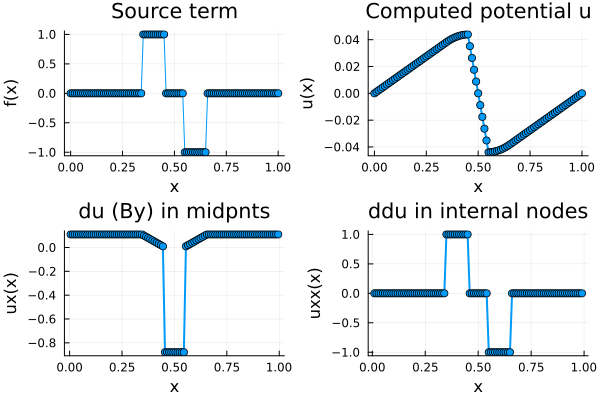

In [26]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 
f = fleft+fright; 

#..construct the diffusion coefficient 
mur = 10000
D = 1 .+ (1/mur-1)*((xmid.>=0.45).*(xmid.<=0.55));

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
A = BT*Diagonal(D)*B; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1.;         A[1,2] = 0.;          f[1] = 0.; 
A[end,end-1]=0;      A[end,end] = 1.;      f[end] = 0.;  

#..solve the linear system
u = A \ f; 

#..compute ux and uxx 
ux = B*u; 
uxx = BT*(D.*ux); 

#..plot the source term and computed solution  
p1=plot(x,f,shape=:circle,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Source term")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Computed potential u")

p3=plot(xmid,ux,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("ux(x)")
title!("du (By) in midpnts")

p4=plot(x[2:end-1],uxx[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("uxx(x)")
title!("ddu in internal nodes")

plot(p1,p2,p3,p4,layout=(2,2))

In [113]:
sum(ux)

2.623457007189245e-13

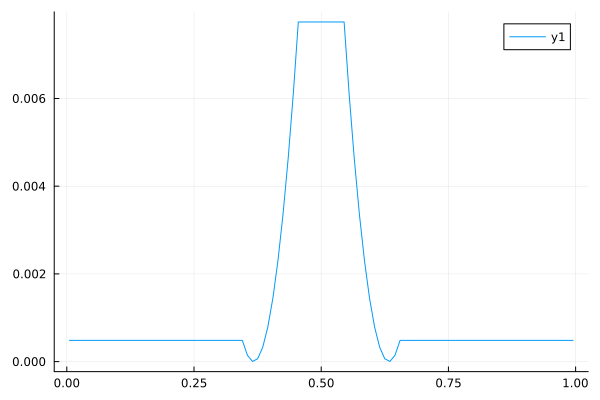

In [117]:
plot(xmid, (D.*ux).*ux)

### Third Study: Magnetic Field Induced by Winding Encircling a Ferromagnetic Yoke with Hole 
<b> Problem Description:</b> Here we extend the previous text case with a ferromagnetic yoke with a hole (or airgap) in the middle. The presence of the airgap is modeled by a drop in magnetic reluctivity.  

<b> Discussion of Numerical Results Obtained:</b>

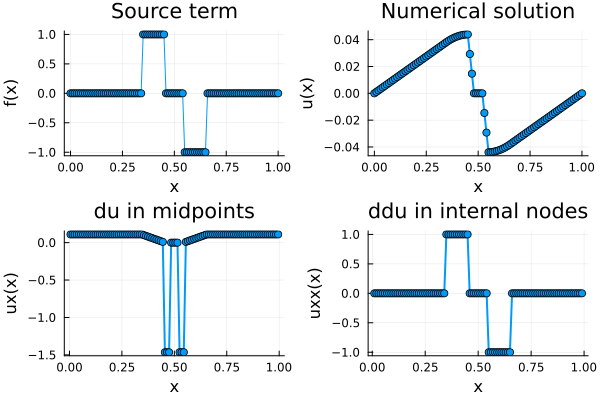

In [108]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 
f = fleft+fright; 

#..construct the diffusion coefficient 
D = 1 .+ (0.0001-1)*((xmid.>=0.45).*(xmid.<=0.475)).+ (0.0001-1)*((xmid.>=0.525).*(xmid.<=0.55));

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
A = BT*Diagonal(D)*B; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1.;          A[1,2] = 0.;          f[1] = 0.; 
A[end,end-1]=0;      A[end,end] = 1.;      f[end] = 0.;  

#..solve the linear system
u = A \ f; 

#..compute ux
ux = B*u; 
uxx = BT*(D.*ux); 

#..plot the source term and computed solution  
p1=plot(x,f,shape=:circle,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Source term")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerical solution")

p3=plot(xmid,ux,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("ux(x)")
title!("du in midpoints")

p4=plot(x[2:end-1],uxx[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("uxx(x)")
title!("ddu in internal nodes")

plot(p1,p2,p3,p4,layout=(2,2))

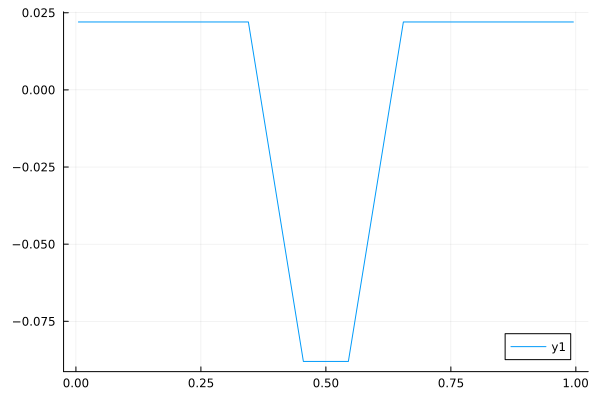

In [118]:
# magnetic field (H-field) in the airgap remains large 
plot(xmid, D.*(ux))

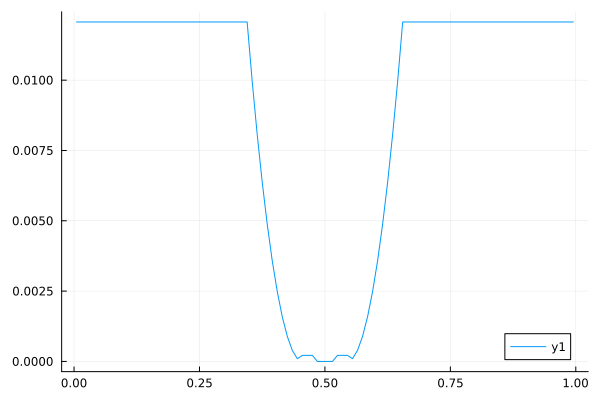

In [110]:
# magnetic energy in the airgap is largest 
plot(xmid, D.*(ux).*ux)

## Section 9: A Closer Look into Julia

Julia employs the concept of multiple dispatch. This means that Julia checks the type of the input variable and chooses the method most specific to that type of variable. In the following, we illustrate this idea for the linear system solve using the backslash operator. The example shows that Julia implements more than hundred methods to perform backslash. 

In [ ]:
A = [1. 2. 3.; 4. 5. 6.; 7. 8. 9.]
b = [1.; 2.; 3]
typeof(A)
methods(\)

## Section 10: Sandbox 